<a href="https://www.kaggle.com/code/farrelad/cic-ids-2017-clustering-case-study?scriptVersionId=265686394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
from pprint import pprint
from pathlib import Path
import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
def detect_environment():
    """Detect if running in Colab, Kaggle, or local environment"""
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'kaggle_secrets' in sys.modules or os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
        return 'kaggle'
    else:
        return 'local'

ENV = detect_environment()
print(f"🔍 Detected environment: {ENV.upper()}")

🔍 Detected environment: KAGGLE


In [3]:
# Download latest version
if ENV == 'kaggle':
    dataset_path = '/kaggle/input/network-intrusion-dataset/'
else: # local environment
    dataset_path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/network-intrusion-dataset/


In [4]:
items = os.listdir(dataset_path)

pprint(items)

['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']


In [5]:
dataset_path = Path(dataset_path)

csv_path = dataset_path / items[-1] # use the last dataset ('Wednesday-workingHours.pcap_ISCX.csv')

# 1. Dataset Understanding and Preparation

## Load data to Pandas dataframe

In [6]:
df = pd.read_csv(csv_path)

df.columns = df.columns.str.strip()

df.head(20)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,389,433,11,4,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,88,1088,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,80,579225,132,150,160,320799,160,0,1.212121,13.926212,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,49666,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,49413,4,3,0,18,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,692703.000000,6.927030e+05,692703.000000,692703.000000,6.927030e+05,6.927030e+05,692703.000000,692703.000000,692703.000000,692703.000000,...,692703.000000,692703.000000,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,5686.869462,2.800168e+07,9.556261,10.214079,5.550930e+02,1.699644e+04,233.593936,15.022183,60.555440,82.895863,...,6.121279,26.761141,9.224478e+04,4.760852e+04,1.627363e+05,6.315186e+04,2.211122e+07,4.743744e+05,2.252174e+07,2.173373e+07
std,15727.423560,4.276680e+07,747.197814,984.204633,6.163663e+03,2.241175e+06,603.751856,51.068835,157.643794,226.126084,...,715.155068,6.322368,7.007049e+05,4.742081e+05,1.094616e+06,6.051023e+05,3.812415e+07,4.488512e+06,3.848292e+07,3.807725e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,2.010000e+02,2.000000,1.000000,1.200000e+01,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,6.143700e+04,2.000000,2.000000,8.200000e+01,1.880000e+02,46.000000,0.000000,41.000000,0.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,8.302437e+07,7.000000,6.000000,3.650000e+02,1.159500e+04,341.000000,32.000000,56.666667,128.916917,...,2.000000,32.000000,9.910000e+02,0.000000e+00,9.910000e+02,9.880000e+02,1.590000e+07,0.000000e+00,1.650000e+07,1.000000e+07
max,65487.000000,1.200000e+08,203943.000000,272353.000000,1.224076e+06,6.270000e+08,24820.000000,2065.000000,4640.757576,6429.190773,...,197124.000000,60.000000,1.000000e+08,7.420000e+07,1.050000e+08,1.000000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             692703 non-null  int64  
 1   Flow Duration                692703 non-null  int64  
 2   Total Fwd Packets            692703 non-null  int64  
 3   Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets  692703 non-null  int64  
 5   Total Length of Bwd Packets  692703 non-null  int64  
 6   Fwd Packet Length Max        692703 non-null  int64  
 7   Fwd Packet Length Min        692703 non-null  int64  
 8   Fwd Packet Length Mean       692703 non-null  float64
 9   Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max        692703 non-null  int64  
 11  Bwd Packet Length Min        692703 non-null  int64  
 12  Bwd Packet Length Mean       692703 non-null  float64
 13 

## Select and clean features

In [9]:
df = df.dropna()  # Remove missing values
X = df.select_dtypes(include=['float64', 'int64'])  # Select numeric columns
X = X.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], errors='ignore')

## Normalize features

In [10]:
# Replace infinity values with NaN and drop rows with NaN
X.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
X.dropna(inplace=True)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Sample 10% of data for faster computation
sample_size = min(10000, len(X_scaled))  # Use max 10k samples
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

df_sample = df.iloc[sample_indices].copy()
X_sample = X_scaled[sample_indices]

# 2. Apply Clustering Algorithms

## k-Means Clustering

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sample)

In [13]:
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    print(f"k={k}, silhouette score={score:.4f}")

k=2, silhouette score=0.9900
k=3, silhouette score=0.4494
k=4, silhouette score=0.4214
k=5, silhouette score=0.3418
k=6, silhouette score=0.3546
k=7, silhouette score=0.2847


## DBSCAN Clustering

In [14]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_sample)

In [15]:
score = silhouette_score(X_sample, dbscan_labels)
print("Silhouette Score (DBSCAN):", score)

Silhouette Score (DBSCAN): 0.20906571495308499


# 3. Evaluate and Interpret

In [16]:
df_sample['Cluster_KMeans'] = kmeans_labels
df_sample['Cluster_DBSCAN'] = dbscan_labels
df_sample['Label'] = df_sample['Label'].astype('category')

print(df_sample.groupby(['Cluster_KMeans', 'Label']).size())
print(df_sample.groupby(['Cluster_DBSCAN', 'Label']).size())

Cluster_KMeans  Label           
0               BENIGN              6372
                DoS GoldenEye        149
                DoS Hulk            3316
                DoS Slowhttptest      81
                DoS slowloris         81
1               BENIGN                 1
                DoS GoldenEye          0
                DoS Hulk               0
                DoS Slowhttptest       0
                DoS slowloris          0
dtype: int64
Cluster_DBSCAN  Label           
-1              BENIGN              989
                DoS GoldenEye        21
                DoS Hulk            183
                DoS Slowhttptest     25
                DoS slowloris        47
                                   ... 
 57             BENIGN                9
                DoS GoldenEye         0
                DoS Hulk              1
                DoS Slowhttptest      0
                DoS slowloris         0
Length: 295, dtype: int64


# 4. Visualization

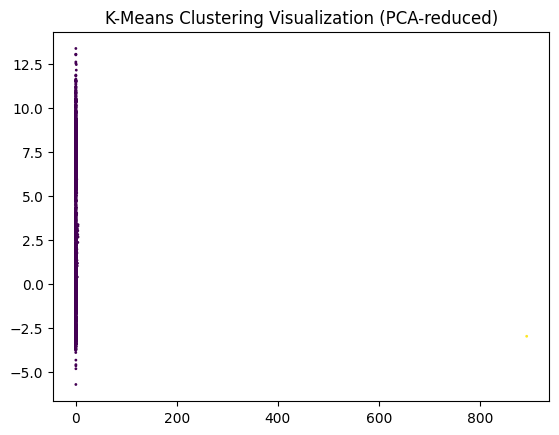

In [17]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_sample)

plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans_labels, cmap='viridis', s=1)
plt.title("K-Means Clustering Visualization (PCA-reduced)")
plt.show()

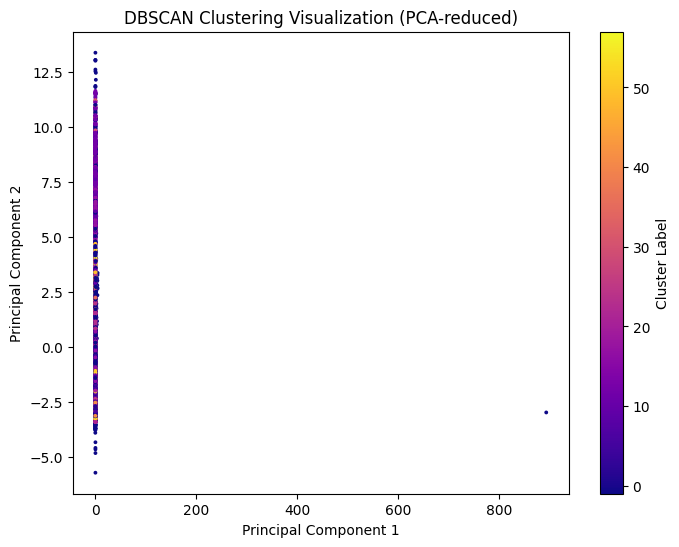

In [18]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_sample)

# Get DBSCAN cluster labels
labels = dbscan_labels

# Plot
plt.figure(figsize=(8,6))
plt.scatter(
    reduced[:, 0], reduced[:, 1],
    c=labels,
    cmap='plasma',
    s=3,
)

plt.title("DBSCAN Clustering Visualization (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# 5. Summary

In [19]:
print("=== CLUSTERING ANALYSIS ===")
print("\n🔍 K-Means Insights:")
print("- Cluster 0: Mixed traffic (mostly benign + some DoS)")
print("- Cluster 1: DoS-heavy cluster (especially DoS Hulk)")
print("- Good separation between normal and attack-heavy traffic")

print("\n🔍 DBSCAN Insights:")
print(f"- Found {len(set(dbscan_labels)) - 1} distinct attack patterns")
print(f"- {list(dbscan_labels).count(-1)} anomalous samples (potential zero-day attacks)")
print("- More granular attack categorization")

print("\n🛡️ Security Applications:")
print("- K-Means: Binary classification (normal vs suspicious)")
print("- DBSCAN: Detailed attack pattern recognition + anomaly detection")
print("- Noise points in DBSCAN are high-priority for investigation")

=== CLUSTERING ANALYSIS ===

🔍 K-Means Insights:
- Cluster 0: Mixed traffic (mostly benign + some DoS)
- Cluster 1: DoS-heavy cluster (especially DoS Hulk)
- Good separation between normal and attack-heavy traffic

🔍 DBSCAN Insights:
- Found 58 distinct attack patterns
- 1265 anomalous samples (potential zero-day attacks)
- More granular attack categorization

🛡️ Security Applications:
- K-Means: Binary classification (normal vs suspicious)
- DBSCAN: Detailed attack pattern recognition + anomaly detection
- Noise points in DBSCAN are high-priority for investigation
